### Import Necessary Libraries

In [1]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity
from scipy.ndimage import gaussian_filter

### Model Config

In [2]:
config_ = 'unet'

### Get and Preprocess Dataset

In [3]:
def add_speckle_noise(image):
    """
    Adds realistic ultrasound-inspired speckle noise to a grayscale image.
    Noise level increases with sigma in [0, 1].

    Parameters:
    - image (np.ndarray): Input grayscale image (2D array).
    - sigma (float): Noise level in [0, 1]; 0 = low, 1 = high

    Returns:
    - noisy_image (np.ndarray): Output image with speckle noise (uint8).
    """
    sigma_list = [0.0, 0.04, 0.08, 0.12, 0.16, 0.20, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
    sigma = random.choice(sigma_list)

    sigma = np.clip(sigma, 0, 1)
    strength = 0.3 + sigma * 0.7     # Linearly scale noise strength from 0.3 to 1.0
    blur_sigma = 0.5 * (1 - sigma)   # Optional blur: less blur at high noise

    # Normalize input
    image = image.astype(np.float32) / 255.0
    height, width = image.shape

    # Generate Rayleigh-distributed noise
    real = np.random.randn(height, width)
    imag = np.random.randn(height, width)
    rayleigh = np.sqrt(real**2 + imag**2)

    # Blur the speckle less as sigma increases
    if blur_sigma > 0 and random.random() <= 0.6:
        speckle = gaussian_filter(rayleigh, sigma=blur_sigma)
    else:
        speckle = rayleigh

    # Normalize and amplify
    speckle /= np.mean(speckle)
    speckle = 1 + strength * (speckle - 1)

    # Apply to image
    noisy = np.clip(image * speckle, 0, 1)

    return (noisy * 255).astype(np.uint8)

# List all image paths
image_dir = "../datasets/coco/original"
all_images = sorted([
    os.path.join(image_dir, fname) for fname in os.listdir(image_dir)
    if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
])

# Split into 95% train, 5% val
train_paths, val_paths = train_test_split(all_images, test_size=0.05, random_state=42)

class ImagePatchDataset(Dataset):
    def __init__(self, image_paths, patch_size=128):
        self.patch_size = patch_size
        self.patches = []

        for img_path in image_paths:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            h, w = img.shape
            for i in range(0, h - patch_size + 1, patch_size):
                for j in range(0, w - patch_size + 1, patch_size):
                    self.patches.append((img_path, i, j))

        print(f"Total patches from {len(image_paths)} images: {len(self.patches)}")

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        img_path, i, j = self.patches[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        patch = img[i:i+self.patch_size, j:j+self.patch_size]
        patch = patch / 255.0

        noisy_patch = add_speckle_noise(patch * 255).astype(np.float32) / 255.0

        return torch.tensor(noisy_patch).unsqueeze(0), torch.tensor(patch).unsqueeze(0)

# Create datasets
train_dataset = ImagePatchDataset(train_paths, patch_size=128)
val_dataset   = ImagePatchDataset(val_paths, patch_size=128)

# Create loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Inspect one batch
for noisy, clean in train_loader:
    print(f"Noisy batch shape: {noisy.shape}")
    print(f"Clean batch shape: {clean.shape}")
    break

print(f"Train patches: {len(train_dataset)}")
print(f"Val patches: {len(val_dataset)}")


Total patches from 4750 images: 65002
Total patches from 250 images: 3429
Noisy batch shape: torch.Size([32, 1, 128, 128])
Clean batch shape: torch.Size([32, 1, 128, 128])
Train patches: 65002
Val patches: 3429


### Visualize Samples

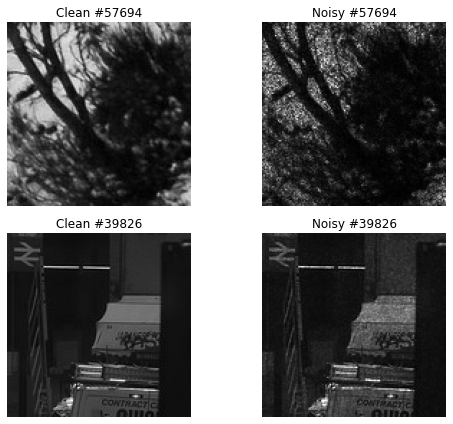

In [4]:
def visualize_n_pairs(dataset, n=5, randomize=True):
    """
    Visualize n (clean, noisy) image pairs from the dataset.

    Parameters:
    - dataset: instance of ImagePatchDataset
    - n (int): number of samples to show
    - randomize (bool): whether to randomly sample or take first n
    """
    indices = random.sample(range(len(dataset)), n) if randomize else list(range(n))

    plt.figure(figsize=(8, 3 * n))

    for idx, sample_idx in enumerate(indices):
        noisy, clean = dataset[sample_idx]
        noisy_img = noisy.squeeze().numpy()
        clean_img = clean.squeeze().numpy()

        # Clean image
        plt.subplot(n, 2, 2 * idx + 1)
        plt.imshow(clean_img, cmap='gray')
        plt.title(f"Clean #{sample_idx}")
        plt.axis("off")

        # Noisy image
        plt.subplot(n, 2, 2 * idx + 2)
        plt.imshow(noisy_img, cmap='gray')
        plt.title(f"Noisy #{sample_idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_n_pairs(train_dataset, n=2, randomize=True)

### Model

In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        # Downsampling path
        for feature in features:
            self.encoder.append(self.double_conv(in_channels, feature))
            in_channels = feature

        # Upsampling path
        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(self.double_conv(feature*2, feature))

        self.bottleneck = self.double_conv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        h, w = x.size()[-2:]
        pad_h = int(np.ceil(h / 64) * 64 - h)
        pad_w = int(np.ceil(w / 64) * 64 - w)
        x = F.pad(x, (0, pad_w, 0, pad_h), mode='replicate')

        skip_connections = []

        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx+1](x)

        x = self.final_conv(x)
        x = x[..., :h, :w]
        return x


### Create Model Instance

In [6]:
# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

### Define the Loss Function

In [7]:
class CombinedMSESSIMLoss(nn.Module):
    def __init__(self, alpha=10):
        super(CombinedMSESSIMLoss, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

    def forward(self, y_true, y_pred):
        # Compute MSE
        mse = self.mse_loss(y_pred, y_true)

        # Compute SSIM per image in batch
        ssim_values = []
        for i in range(y_true.size(0)):
            y_true_np = y_true[i].squeeze().detach().cpu().numpy()
            y_pred_np = y_pred[i].squeeze().detach().cpu().numpy()
            ssim_val = structural_similarity(y_true_np, y_pred_np, data_range=1.0, win_size=7)
            ssim_values.append(ssim_val)

        # Average SSIM and compute combined loss
        ssim_loss = 1.0 - np.mean(ssim_values)
        combined = mse + (self.alpha * ssim_loss) ** 2
        return combined

loss_ = 'ps'
criterion = CombinedMSESSIMLoss(alpha=10)

# Define Optimizer and Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)


### Train the Model

In [ ]:
# Make sure checkpoints directory exists
os.makedirs("../checkpoints", exist_ok=True)

# Initialize model, optimizer, scheduler
model = UNet(in_channels=1).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# Training loop
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100):
    best_val_loss = float('inf')
    history = {"train_loss": [], "val_loss": []}  # Track history

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")

        for noisy, clean in loop:
            noisy, clean = noisy.to(device), clean.to(device)

            optimizer.zero_grad()
            output = model(noisy)
            loss = criterion(clean, output)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * noisy.size(0)
            loop.set_postfix(loss=loss.item())

        train_loss /= len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for noisy, clean in val_loader:
                noisy, clean = noisy.to(device), clean.to(device)
                output = model(noisy)
                loss = criterion(clean, output)
                val_loss += loss.item() * noisy.size(0)

        val_loss /= len(val_loader.dataset)
        scheduler.step()

        # Save loss to history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(f"\nEpoch {epoch+1} Summary: Train Loss = {train_loss:.6f} | Val Loss = {val_loss:.6f}")

        #  Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_path = f"../checkpoints/{config_}-{loss_}.pth.pth"
            torch.save(model.state_dict(), best_path)
            print(" Saved Best Model!")

    #  Save final model
    final_path = f"../checkpoints/{config_}-{loss_}.pth-final.pth"
    torch.save(model.state_dict(), final_path)
    print(" Saved Final Model!")

    return history  # Return loss history

# Train the model
history = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=100
)
